In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [1]:
import tensorflow.keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns



0      0.088031
1      0.090132
2      0.088110
3      0.087263
4      0.098356
         ...   
735    0.141685
736    0.143429
737    0.144315
738    0.144350
739    0.144685
Name: dmb, Length: 740, dtype: float64
0      0.120219
1      0.121435
2      0.089552
3      0.119729
4      0.100088
         ...   
735    0.185894
736    0.193666
737    0.184957
738    0.175960
739    0.160803
Name: dmb, Length: 740, dtype: float64


array([ 1.299106  , 26.046776  ,  0.25168409])

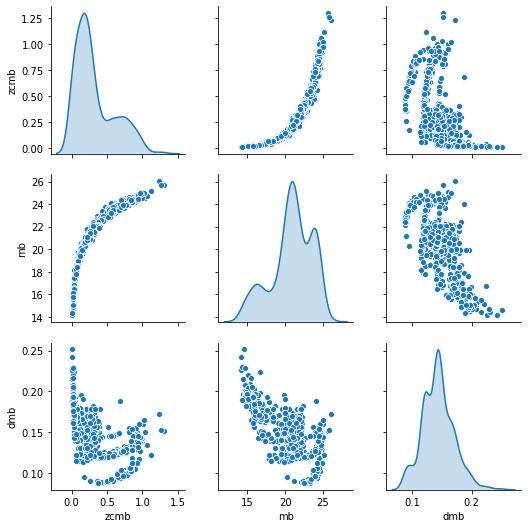

In [5]:
file = 'data/jla_lcparams.txt'
data = pd.read_csv(file, sep = " " ,usecols=['zcmb', 'mb', 'dmb'])
print(data['dmb'])
syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))
diag = np.diag(syscov)
data['dmb'] = np.sqrt(diag + data['dmb']**2)
print(data['dmb'])
sns.pairplot(data, diag_kind="kde")
plt.savefig("distSNPantheon.png")
data = np.sort(data.values, axis=0)
data[739, :]


In [6]:
# randomize = np.random.permutation(len(data.values))
# randomize
shuffle = [x for x in range(len(data)) if x%2==1]
even = [x for x in range(len(data)) if x%2==0]
shuffle.extend(even)
np.max(shuffle)

739

Let's prepare our input data. 

In [8]:
print(data[739, 0])
data = data[shuffle]

1.2991059999999999


In [9]:
X = data[:, 0]
y = data[:, 1:]
X.shape, y.shape

((740,), (740, 2))

In [10]:
split = 0.8
ntrain = int(split * len(X))
indx = [ntrain]
X_train, X_test = np.split(X, indx)
y_train, y_test = np.split(y, indx)

In [11]:
# scaler = StandardScaler()
# # scaler = MinMaxScaler(feature_range=(-1,1))
# # fit scaler on data
# scaler.fit(X.reshape(-1,1))
# # apply transform
# X = scaler.transform(X.reshape(-1,1))
# # X

In [12]:
def model(input_z):
    efirst = Dense(100, activation='relu', input_shape=(1,))(input_z)
    ehidden2 = Dense(100, activation='relu')(efirst)
    ehidden3 = Dense(100, activation='relu')(ehidden2)
    elast = Dense(2, activation='linear')(ehidden3)
       
    return elast

In [13]:
batch_size = 32
epochs = 300
input_z = Input(shape = (1,))

In [14]:
snmodel = Model(input_z, model(input_z))
snmodel.compile(loss='mean_squared_error', optimizer = 'adam')

In [15]:
snmodel.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
Total params: 20,602
Trainable params: 20,602
Non-trainable params: 0
_________________________________________________________________


In [16]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.001,
                                   patience=10,
                                   restore_best_weights=True)]

In [17]:
snmodel_train = snmodel.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1, 
                            validation_data=(X_test, y_test))

Epoch 1/300
19/19 [==============================] - 0s 5ms/step - loss: 205.0428 - val_loss: 251.8966
Epoch 2/300
19/19 [==============================] - 0s 1ms/step - loss: 182.5472 - val_loss: 182.6194
Epoch 3/300
19/19 [==============================] - 0s 2ms/step - loss: 115.7791 - val_loss: 42.3788
Epoch 4/300
19/19 [==============================] - 0s 1ms/step - loss: 25.2032 - val_loss: 39.5410
Epoch 5/300
19/19 [==============================] - 0s 1ms/step - loss: 10.6668 - val_loss: 17.2171
Epoch 6/300
19/19 [==============================] - 0s 2ms/step - loss: 7.0656 - val_loss: 14.3994
Epoch 7/300
19/19 [==============================] - 0s 1ms/step - loss: 5.5553 - val_loss: 12.7533
Epoch 8/300
19/19 [==============================] - 0s 1ms/step - loss: 4.3951 - val_loss: 8.8733
Epoch 9/300
19/19 [==============================] - 0s 1ms/step - loss: 3.5812 - val_loss: 8.1902
Epoch 10/300
19/19 [==============================] - 0s 1ms/step - loss: 2.9495 - val_loss:

19/19 [==============================] - 0s 1ms/step - loss: 0.1842 - val_loss: 0.0429
Epoch 83/300
19/19 [==============================] - 0s 1ms/step - loss: 0.1814 - val_loss: 0.0531
Epoch 84/300
19/19 [==============================] - 0s 1ms/step - loss: 0.1750 - val_loss: 0.0459
Epoch 85/300
19/19 [==============================] - 0s 1ms/step - loss: 0.1717 - val_loss: 0.0414
Epoch 86/300
19/19 [==============================] - 0s 1ms/step - loss: 0.1675 - val_loss: 0.0412
Epoch 87/300
19/19 [==============================] - 0s 1ms/step - loss: 0.1642 - val_loss: 0.0409
Epoch 88/300
19/19 [==============================] - 0s 1ms/step - loss: 0.1599 - val_loss: 0.0424
Epoch 89/300
19/19 [==============================] - 0s 1ms/step - loss: 0.1558 - val_loss: 0.0483
Epoch 90/300
19/19 [==============================] - 0s 1ms/step - loss: 0.1539 - val_loss: 0.0545
Epoch 91/300
19/19 [==============================] - 0s 1ms/step - loss: 0.1557 - val_loss: 0.0475
Epoch 92/300


19/19 [==============================] - 0s 1ms/step - loss: 0.0806 - val_loss: 0.0760
Epoch 164/300
19/19 [==============================] - 0s 1ms/step - loss: 0.0836 - val_loss: 0.0639
Epoch 165/300
19/19 [==============================] - 0s 1ms/step - loss: 0.0753 - val_loss: 0.0588
Epoch 166/300
19/19 [==============================] - 0s 1ms/step - loss: 0.0784 - val_loss: 0.0554
Epoch 167/300
19/19 [==============================] - 0s 1ms/step - loss: 0.0740 - val_loss: 0.0601
Epoch 168/300
19/19 [==============================] - 0s 1ms/step - loss: 0.0767 - val_loss: 0.0659
Epoch 169/300
19/19 [==============================] - 0s 1ms/step - loss: 0.0751 - val_loss: 0.0934
Epoch 170/300
19/19 [==============================] - 0s 1ms/step - loss: 0.0770 - val_loss: 0.1033
Epoch 171/300
19/19 [==============================] - 0s 1ms/step - loss: 0.0758 - val_loss: 0.0657
Epoch 172/300
19/19 [==============================] - 0s 1ms/step - loss: 0.0752 - val_loss: 0.0647
Epoc

19/19 [==============================] - 0s 1ms/step - loss: 0.0474 - val_loss: 0.0290
Epoch 245/300
19/19 [==============================] - 0s 2ms/step - loss: 0.0453 - val_loss: 0.0119
Epoch 246/300
19/19 [==============================] - 0s 1ms/step - loss: 0.0457 - val_loss: 0.0363
Epoch 247/300
19/19 [==============================] - 0s 1ms/step - loss: 0.0487 - val_loss: 0.0270
Epoch 248/300
19/19 [==============================] - 0s 1ms/step - loss: 0.0625 - val_loss: 0.1364
Epoch 249/300
19/19 [==============================] - 0s 1ms/step - loss: 0.0521 - val_loss: 0.0208
Epoch 250/300
19/19 [==============================] - 0s 1ms/step - loss: 0.0448 - val_loss: 0.0128
Epoch 251/300
19/19 [==============================] - 0s 1ms/step - loss: 0.0419 - val_loss: 0.0356
Epoch 252/300
19/19 [==============================] - 0s 1ms/step - loss: 0.0495 - val_loss: 0.0397
Epoch 253/300
19/19 [==============================] - 0s 1ms/step - loss: 0.0550 - val_loss: 0.0142
Epoc

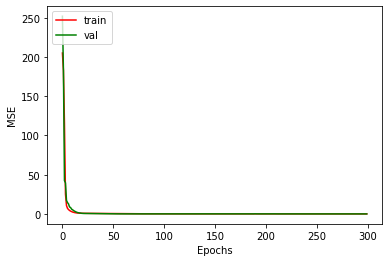

In [18]:
plt.plot(snmodel_train.history['loss'], color='r', )
plt.plot(snmodel_train.history['val_loss'], color='g')
# plt.title('model loss function')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend(['train', 'val'], loc='upper left')
# plt.savefig("loss_sn.png", dpi=200)

In [19]:
pred = snmodel.predict(X_test)
pred.shape

(148, 2)

In [20]:
pred

array([[21.55641   ,  0.15283069],
       [21.573862  ,  0.15302455],
       [21.589231  ,  0.15319557],
       [21.601307  ,  0.15332937],
       [21.634348  ,  0.1536967 ],
       [21.654436  ,  0.15392017],
       [21.673756  ,  0.15413482],
       [21.69031   ,  0.15431866],
       [21.702957  ,  0.15445901],
       [21.720629  ,  0.15465543],
       [21.745878  ,  0.15493608],
       [21.768929  ,  0.15519205],
       [21.78353   ,  0.155354  ],
       [21.79868   ,  0.15552275],
       [21.843685  ,  0.15602253],
       [21.858284  ,  0.15618484],
       [21.883204  ,  0.15646163],
       [21.898132  ,  0.15662746],
       [21.922613  ,  0.15689963],
       [21.961908  ,  0.15733595],
       [22.005709  ,  0.1578229 ],
       [22.071024  ,  0.1585483 ],
       [22.09265   ,  0.15878862],
       [22.116142  ,  0.1590496 ],
       [22.121847  ,  0.15911342],
       [22.158403  ,  0.15951945],
       [22.207142  ,  0.16006035],
       [22.285387  ,  0.16093013],
       [22.325256  ,

In [22]:
r = np.random.uniform(0, 2.3, size=10000)
# rr = scaler.transform(r.reshape(-1,1))
# X = scaler.inverse_transform(X)
# X
print(np.max(X), len(X), X[739])

1.2991059999999999 740 1.265901


In [23]:
pred_random = snmodel.predict(r)
# pred_random

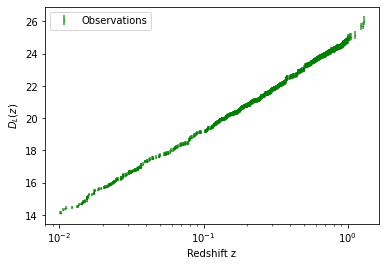

In [32]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.errorbar(X, y[:,0], y[:,1], fmt='g.', markersize=1, label='Observations', alpha=0.8)
# plt.errorbar(r, pred_random[:,0], pred_random[:,1], fmt='r*', markersize=3, label='Synthetic', alpha=0.01)
plt.xlabel("Redshift z")
plt.ylabel("$D_L(z)$")
ax.set_xscale('log')
# plt.ylim(34, 40)
# plt.xlim(np.min(X), 2.4)
plt.legend()
# plt.savefig("syntheticSN.png", dpi=300)

In [25]:
# Cosmological constants
Om = 0.27

In [22]:
def Hlcdm(z, H0=73.24):
    return H0 * np.sqrt(Om*(1+z)**3 + 1 - Om)

In [23]:
# z = np.linspace(0, 2.2, 1000)
# # plt.scatter(data[:, 0], data[:, 1], c='g')
# yupp = pred_random[:,0]+pred_random[:,1]
# ylow = pred_random[:,0]-pred_random[:,1]
# plt.errorbar(X, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations')
# plt.errorbar(r, pred_random[:,0], pred_random[:,1], fmt='r.', markersize=1, label='Synthetic data with errors', alpha=0.01, )
# plt.plot(z, Hlcdm(z), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
# plt.plot(z, Hlcdm(z, H0=64.4), label='$\Lambda CDM$ $H_0 = 64.4$', c='b')
# plt.xlabel("Redshift z")
# plt.ylabel("$H(z)$")
# plt.xlim(0,2.2)
# plt.legend()

# plt.savefig("SyntheticHD.png",dpi=800)

In [24]:
# pred_random.shape, r.shape

In [50]:
# rr = np.random.uniform(0, 2.3, size=500)
rr = np.linspace(0, 2.3, num=500)
print(len(rr))
pred_random = snmodel.predict(rr)
mookSN = np.concatenate((rr.reshape(-1,1), pred_random), axis=1)
np.savetxt("neuralSN.dat",mookSN, delimiter=" ")

500


In [51]:
rr

array([0.        , 0.00460922, 0.00921844, 0.01382766, 0.01843687,
       0.02304609, 0.02765531, 0.03226453, 0.03687375, 0.04148297,
       0.04609218, 0.0507014 , 0.05531062, 0.05991984, 0.06452906,
       0.06913828, 0.07374749, 0.07835671, 0.08296593, 0.08757515,
       0.09218437, 0.09679359, 0.10140281, 0.10601202, 0.11062124,
       0.11523046, 0.11983968, 0.1244489 , 0.12905812, 0.13366733,
       0.13827655, 0.14288577, 0.14749499, 0.15210421, 0.15671343,
       0.16132265, 0.16593186, 0.17054108, 0.1751503 , 0.17975952,
       0.18436874, 0.18897796, 0.19358717, 0.19819639, 0.20280561,
       0.20741483, 0.21202405, 0.21663327, 0.22124248, 0.2258517 ,
       0.23046092, 0.23507014, 0.23967936, 0.24428858, 0.2488978 ,
       0.25350701, 0.25811623, 0.26272545, 0.26733467, 0.27194389,
       0.27655311, 0.28116232, 0.28577154, 0.29038076, 0.29498998,
       0.2995992 , 0.30420842, 0.30881764, 0.31342685, 0.31803607,
       0.32264529, 0.32725451, 0.33186373, 0.33647295, 0.34108